In [45]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import normaltest, mannwhitneyu, spearmanr
import pingouin as pg
import statsmodels.api as sm
from cliffs_delta import cliffs_delta

In [46]:
sb.set_context('paper', font_scale = 1.75)
sb.set_style("ticks", {'patch.edgecolor': 'black'})
sb.set_palette("tab10")

# Data preparation

In [47]:
categories = {
    'rating_1': 'Related',
    'rating_2': 'Unambiguous',
    'rating_3': 'Contextual',
    'rating_4': 'Insightful',
}

In [48]:
df_issues: pd.DataFrame = pd.read_csv('data/backend_issues.csv')
df_rating: pd.DataFrame = pd.read_csv('data/backend_rating.csv')

# Data provided by Herbold et al. (2020)
df_train_data: pd.DataFrame = pd.read_pickle('data/train_data_all.p')

## Complete the issues table

In [49]:
# Add project key to each issue
for key in df_train_data.keys():
    df_train_data[key]['project'] = key

df_train_data = pd.concat(df_train_data[key] for key in df_train_data.keys())

# Merge with issues table from backend to get the result of the classification
df_issues = pd.merge(df_issues, df_train_data[['title', 'description', 'classification', 'project']], how='left', on=['title', 'description', 'project'])
df_issues.drop_duplicates(['id', 'classification'], inplace=True)
df_issues.reset_index(inplace=True)

# Extract prediction values which are stored as strings
def prediction_to_number(input: str):
    prediction: list = input.strip('"[]').split(', ')
    return 0 if prediction[0] > prediction[1] else 1

df_issues['classification'] = df_issues['classification'].astype(int)
df_issues['prediction'] = df_issues['prediction'].apply(lambda x: prediction_to_number(json.loads(x)))
df_issues['tp'] = df_issues[['prediction', 'classification']].apply(lambda x: (x['classification'] and x['prediction'] == 1), axis=1).astype(bool)
df_issues['tn'] = df_issues[['prediction', 'classification']].apply(lambda x: (not x['classification'] and x['prediction'] == 0), axis=1).astype(bool)
df_issues['fp'] = df_issues[['prediction', 'classification']].apply(lambda x: (not x['classification'] and x['prediction'] == 1), axis=1).astype(bool)
df_issues['fn'] = df_issues[['prediction', 'classification']].apply(lambda x: (x['classification'] and x['prediction'] == 0), axis=1).astype(bool)
df_issues = df_issues.join(pd.get_dummies(df_issues['project'], dtype=int))

## Complete the ratings table

In [50]:
# Reconstruct rating order
user_cnt = {}

def get_n(user: str, algorithm: str):
    global user_cnt
    if not user in user_cnt:
        user_cnt[user] = 0
    if algorithm == 'shap':
        user_cnt[user] += 1

    return user_cnt[user]


df_rating['n'] = df_rating.apply(lambda x: get_n(x['user_id'], x['algorithm']), axis=1)

# Add issue information
df_rating = pd.merge(df_rating, df_issues, how='left', left_on=['issue_id'], right_on=['id'], suffixes=('', '_merged'))

## Create table for $qs$

In [51]:
def get_mean_data(df_rating_subset):

    mean_data = []

    for keys, group in df_rating_subset.groupby(['issue_id', 'algorithm']):
        qs = (group['rating_1'] + group['rating_2'] + group['rating_3'] + group['rating_4']).mean()
        mean_data.append({
            'issue_id': keys[0],
            'algorithm': keys[1],
            'qs': qs,
            'rating_1': group['rating_1'].mean(),
            'rating_2': group['rating_2'].mean(),
            'rating_3': group['rating_3'].mean(),
            'rating_4': group['rating_4'].mean(),
            'n1': group[group['user_id'] == 2]['n'].iloc[0], # starting at 2 because rater 1 is the admin
            'n2': group[group['user_id'] == 3]['n'].iloc[0],
            'n3': group[group['user_id'] == 4]['n'].iloc[0],
        })

    result = pd.DataFrame(mean_data)
    return pd.merge(result, df_issues, how='left', left_on=['issue_id'], right_on=['id'], suffixes=('', '_merged'))

df_mean = get_mean_data(df_rating)

# Generate project contents overview

In [52]:
df_dataset_count = df_issues.groupby(by=['project', 'classification']).size().unstack()

for cat in ['tp', 'tn', 'fp', 'fn']:
    df_tmp = df_issues[['project', cat, 'index']].groupby(by=['project', cat]).count().unstack()
    df_tmp.columns = df_tmp.columns.to_flat_index()
    df_tmp = df_tmp.reset_index()
    df_tmp[cat] = df_tmp[('index', True)].fillna(0).astype(int)
    df_dataset_count = pd.merge(df_dataset_count, df_tmp[['project', cat]], on='project', suffixes=('', '_' + cat))

df_dataset_count['total'] = df_dataset_count[0] + df_dataset_count[1]
df_dataset_count

,project,0,1,tp,tn,fp,fn,total
0,ant-ivy,74,42,34,70,4,8,116
1,archiva,82,30,24,77,5,6,112
2,calcite,104,39,35,102,2,4,143
3,cayenne,134,38,37,125,9,1,172
4,commons-bcel,9,4,4,8,1,0,13
5,commons-beanutils,22,5,4,22,0,1,27
6,commons-codec,15,3,3,15,0,0,18
7,commons-collections,38,5,5,38,0,0,43
8,commons-compress,25,12,12,23,2,0,37
9,commons-configuration,34,14,12,27,7,2,48


# Analysis

## Category statistics

Arithmetic mean (M), standard deviation (SD) and Cronbach's $\alpha$ between the three raters for the ratings per category as well as for the subsets of explanations by LIME and SHAP.

In [53]:
def get_rating_per_rater(category: str, user_ids: list[int]):
    """ Returns a new DataFrame with rows for each user_id filled with the users rating of category
    
    """
    agreement_table = pd.DataFrame()

    for user_id in user_ids:
        df_user_rating = df_rating[df_rating['user_id'] == user_id][['issue_id', 'algorithm', category]]
        df_user_rating[f'{user_id}'] = df_user_rating[category].astype(float)
        df_user_rating.drop(category, axis=1, inplace=True)

        if not agreement_table.empty:
            agreement_table = pd.merge(agreement_table, df_user_rating, how='left', on=['issue_id', 'algorithm'])
        else:
            agreement_table = df_user_rating

    return agreement_table.dropna()

def get_cronbachs_alpha(rating_table: pd.DataFrame):
    return pg.cronbach_alpha(data=rating_table.drop(['issue_id', 'algorithm'], axis=1), items=['rater_2_qs', 'rater_4_qs'])

In [54]:
user_ids = [2, 3, 4]

result = []

for category in categories.keys():
    raters_table = get_rating_per_rater(category, user_ids)
    alpha, _ = get_cronbachs_alpha(raters_table)
    alpha_lime, _ = get_cronbachs_alpha(raters_table[raters_table['algorithm'] == 'lime'])
    alpha_shap, _ = get_cronbachs_alpha(raters_table[raters_table['algorithm'] == 'shap'])
    result.append({'category': categories[category], 
    'all': {
        'M': df_rating[category].mean(),
        'SD': df_rating[category].std(),
        '$\\alpha$': alpha
    }, 
    'lime': {
        'M': df_rating[df_rating['algorithm'] == 'lime'][category].mean(),
        'SD': df_rating[df_rating['algorithm'] == 'lime'][category].std(),
        'crombachs $\\alpha$': alpha_lime
    }, 
    'shap': {
        'M': df_rating[df_rating['algorithm'] == 'shap'][category].mean(),
        'SD': df_rating[df_rating['algorithm'] == 'shap'][category].std(),
        'crombachs $\\alpha$': alpha_shap
    }})

pd.json_normalize(result).round(3)

,category,all.M,all.SD,all.$\alpha$,lime.M,lime.SD,lime.crombachs $\alpha$,shap.M,shap.SD,shap.crombachs $\alpha$
0,Related,0.723,0.519,0.304,0.719,0.518,0.292,0.728,0.520,0.338
1,Unambiguous,0.300,0.669,0.256,0.210,0.671,0.229,0.390,0.654,0.212
2,Contextual,0.473,0.647,0.151,0.370,0.658,0.290,0.576,0.619,0.187
3,Insightful,0.516,0.678,0.358,0.471,0.677,0.424,0.562,0.675,0.327


## Inter rater agreement

Spearman's $\rho$ between the raters regarding the four categories and the dependent variable $qs$.

In [55]:
result = []
user_ids = [2 ,3, 4]

while len(user_ids) > 0:
    user_a = user_ids.pop(0)
    for user_b in user_ids:
        for category in list(categories.keys()):
            rating_per_rater = get_rating_per_rater(category, [user_a, user_b])
            statistic, pvalue = spearmanr(rating_per_rater[[f'{user_id}' for user_id in [user_a, user_b]]])
            result.append({
                'Raters': f'(R{user_a}, R{user_b})', 
                'Category': categories[category], 
                'Spearman statistic': round(statistic, 3), 
                'p-value': round(pvalue, 3)
            })

pd.DataFrame(result)

,Raters,Category,Spearman statistic,p-value
0,"(R2, R3)",Related,0.054,0.000
1,"(R2, R3)",Unambiguous,0.070,0.000
2,"(R2, R3)",Contextual,0.025,0.054
3,"(R2, R3)",Insightful,0.051,0.000
4,"(R2, R4)",Related,0.288,0.000
5,"(R2, R4)",Unambiguous,0.138,0.000
6,"(R2, R4)",Contextual,0.230,0.000
7,"(R2, R4)",Insightful,0.356,0.000
8,"(R3, R4)",Related,0.024,0.059
9,"(R3, R4)",Unambiguous,0.135,0.000


## Distribution of $qs$

Distribution of $qs$ (a) per algorithm; (b) for predictions as bugs ($tp$, $fp$) and non-bugs ($tn$, $fn$); (c) correct predictions ($tp$, $tn$) and incorrect predictions ($fp$, $fn$); and (d) correct predictions of bugs ($tp$) and correct predictions of non-bugs ($tn$).

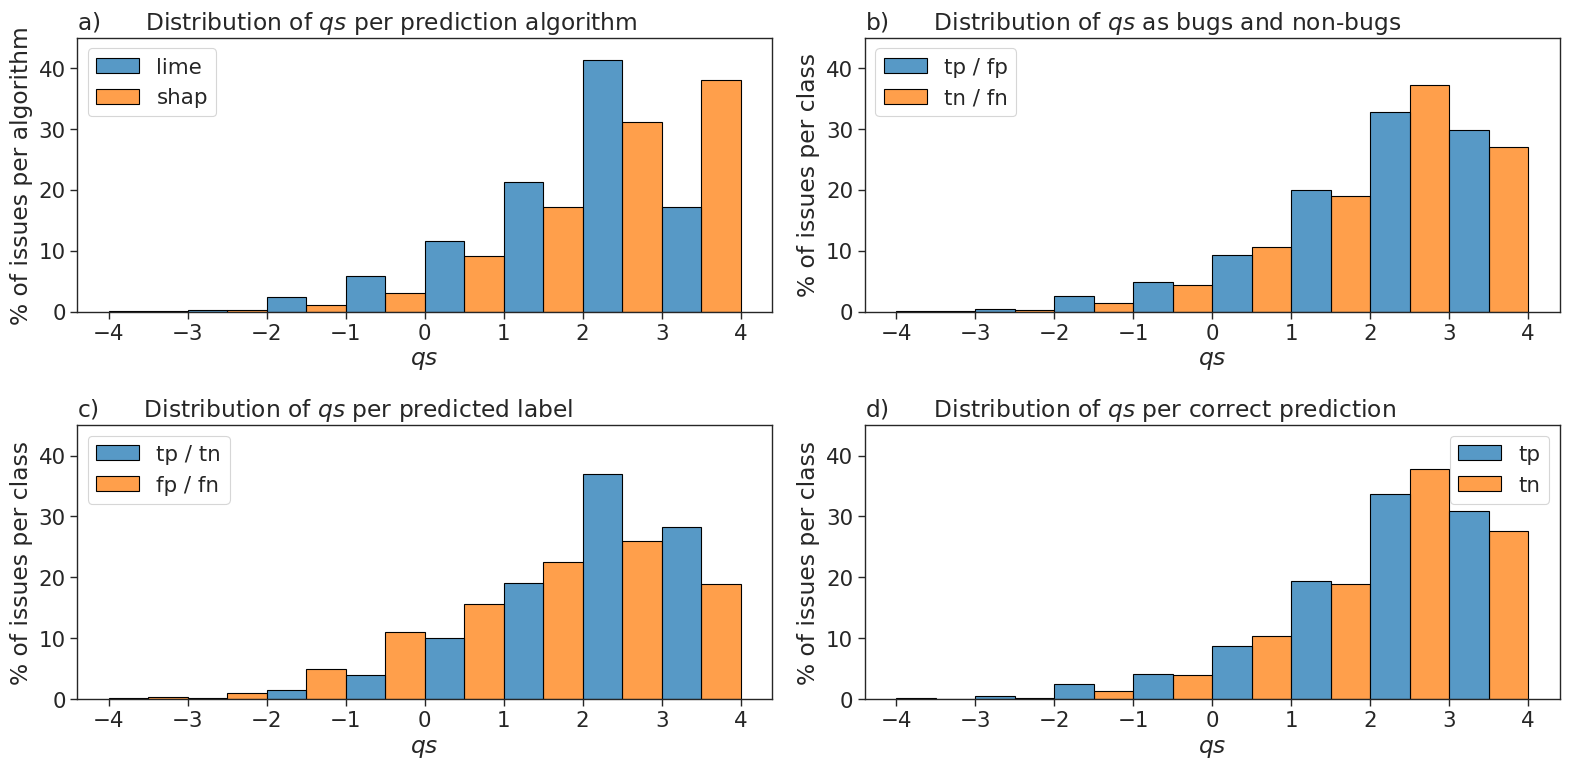

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,8))

ylim = 45

a = pd.DataFrame({
    'lime': df_mean[df_mean['algorithm'] == 'lime']['qs'], 
    'shap': df_mean[df_mean['algorithm'] == 'shap']['qs'], 
})
sb.histplot(a, bins=8, ax=ax1, stat="percent", common_norm=False, multiple='dodge')

ax1.set_title('a)\tDistribution of $qs$ per prediction algorithm', loc='left')
ax1.set_ylabel(r'% of issues per algorithm')
ax1.set_xlabel('$qs$')
ax1.set_ylim([0, ylim])

a = pd.DataFrame({
    'tp / fp': df_mean[(df_mean['tp'] == 1) | (df_mean['fp'] == 1)]['qs'], 
    'tn / fn': df_mean[(df_mean['tn'] == 1) | (df_mean['fn'] == 1)]['qs'], 
})
sb.histplot(a, bins=8, ax=ax2, stat="percent", common_norm=False, multiple='dodge')

ax2.set_title('b)\tDistribution of $qs$ as bugs and non-bugs', loc='left')
ax2.set_ylabel(r'% of issues per class')
ax2.set_xlabel('$qs$')
ax2.set_ylim([0, ylim])

b = pd.DataFrame({
    'tp / tn': df_mean[(df_mean['tp'] == 1) | (df_mean['tn'] == 1)]['qs'], 
    'fp / fn': df_mean[(df_mean['fp'] == 1) | (df_mean['fn'] == 1)]['qs'], 
})

sb.histplot(b, bins=8, ax=ax3, stat="percent", common_norm=False, multiple='dodge')

ax3.set_title('c)\tDistribution of $qs$ per predicted label', loc='left')
ax3.set_ylabel(r'% of issues per class')
ax3.set_xlabel('$qs$')
ax3.set_ylim([0, ylim])

a = pd.DataFrame({
    'tp': df_mean[(df_mean['tp'] == 1)]['qs'], 
    'tn': df_mean[(df_mean['tn'] == 1)]['qs'], 
})
sb.histplot(a, bins=8, ax=ax4, stat="percent", common_norm=False, multiple='dodge')

ax4.set_title('d)\tDistribution of $qs$ per correct prediction', loc='left')
ax4.set_ylabel(r'% of issues per class')
ax4.set_xlabel('$qs$')
ax4.set_ylim([0, ylim])

fig.tight_layout()

plt.savefig('plots/distribution_of_qs.pdf', bbox_inches="tight")

## Distribution of ratings per category, per algorithm.

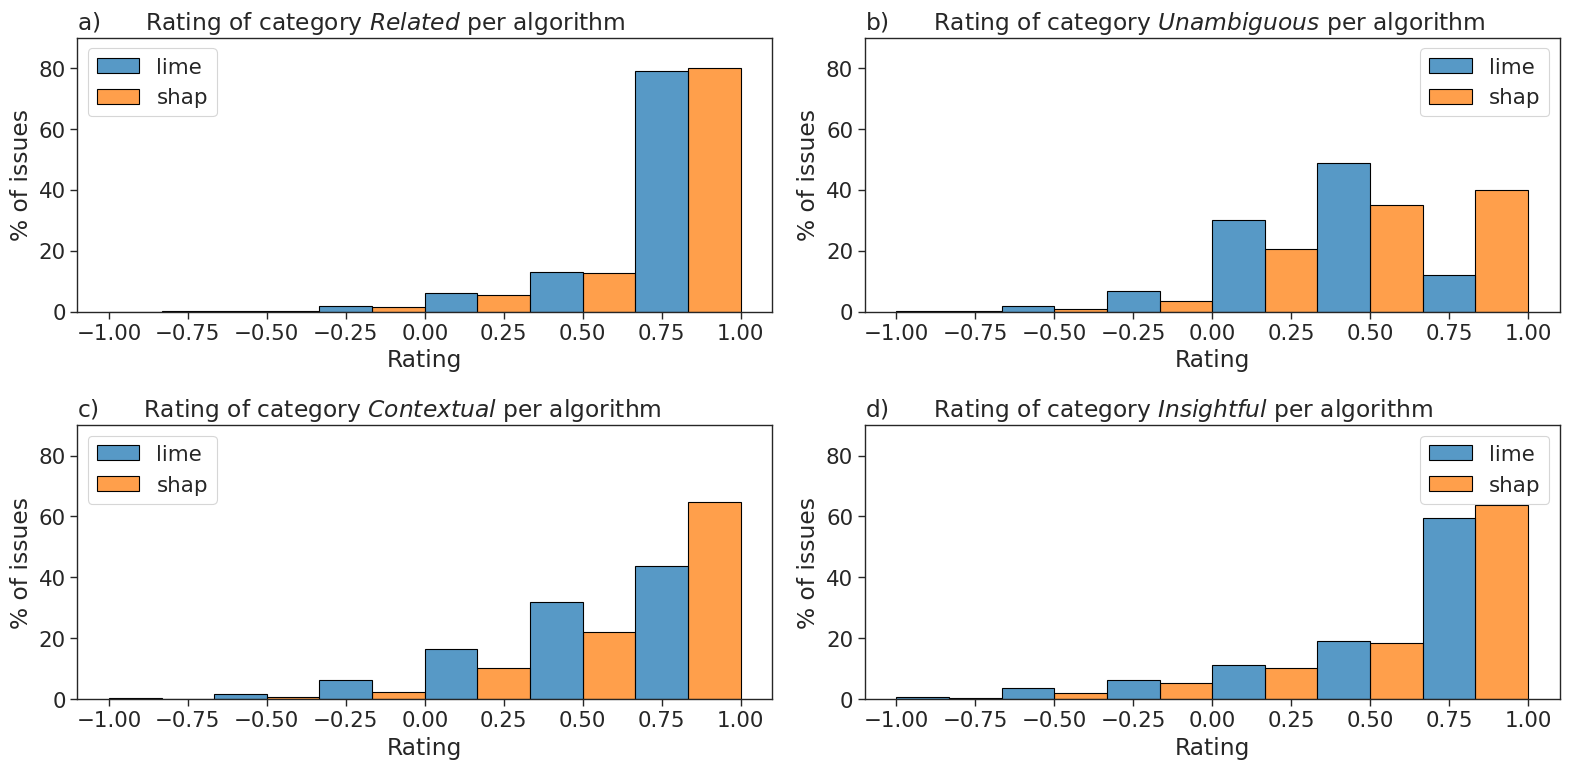

In [57]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,8))

axs = [None, ax1, ax2, ax3, ax4]
for i in range(1, 5):

    category = categories[f'rating_{i}']
    ax = axs[i]
    ax.set_title(f'{["a", "b", "c", "d"][i-1]})\tRating of category ${category}$ per algorithm', loc='left')

    df_tmp = pd.DataFrame({
        'lime': df_mean[df_mean['algorithm'] == 'lime'][f'rating_{i}'],
        'shap': df_mean[df_mean['algorithm'] == 'shap'][f'rating_{i}']
    })
    sb.histplot(df_tmp, bins=6, ax=ax, stat="percent", common_norm=False, multiple='dodge', fill=True)
    ax.set_xlabel(f'Rating')
    ax.set_ylabel(f'% of issues')
    ax.set_ylim([0, 90])

fig.tight_layout()

plt.savefig('plots/distribution_of_categories.pdf', bbox_inches="tight")

## Correlation of categories

Correlation between the ratings per category, calculated with Spearman's $\rho$.

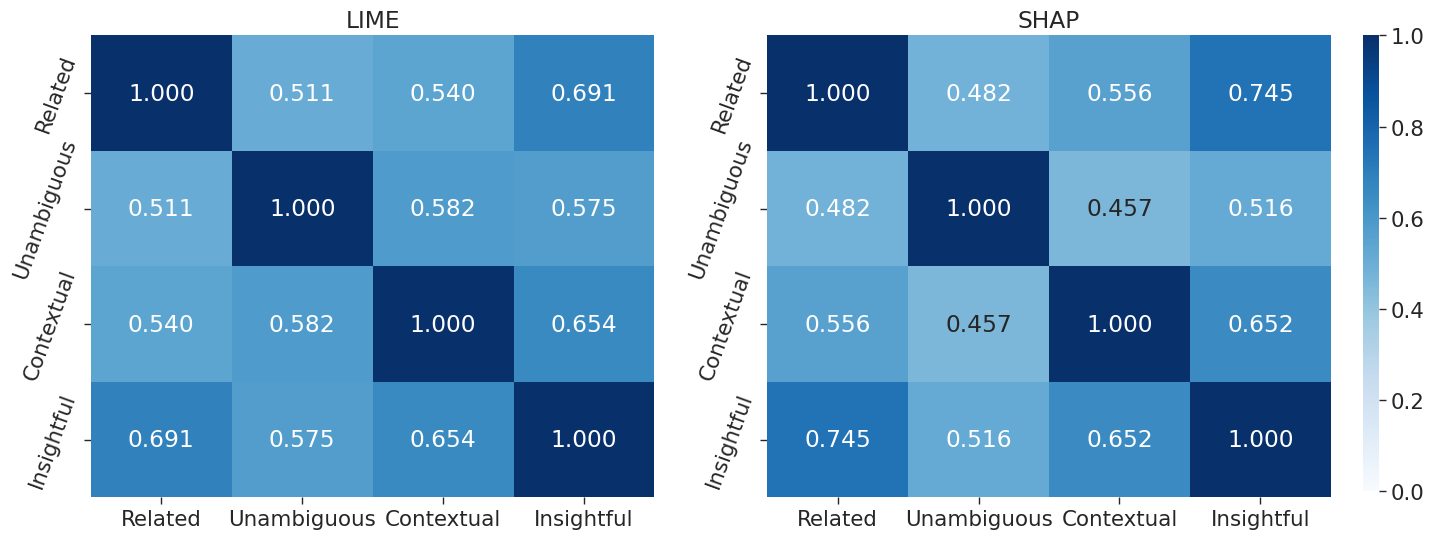

In [58]:
fig, ((ax2, ax1)) = plt.subplots(1, 2, figsize=(16,6))
cmap = sb.color_palette("Blues", as_cmap=True)

labels = [category for category in list(categories.values()) ]
cbar_ax = fig.add_axes([.92, .12, .01, .76])

df_rating_lime = df_mean[df_mean['algorithm'] == 'lime'][['rating_1', 'rating_2', 'rating_3', 'rating_4']]

ax2.set_title('LIME')
ax2 = sb.heatmap(df_rating_lime.corr(method='spearman'), xticklabels=labels, yticklabels=labels, annot = True, fmt='.3f', vmin=0, vmax=1, cmap=cmap, ax=ax2, cbar_ax=cbar_ax)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=70)

df_rating_shap = df_mean[df_mean['algorithm'] == 'shap'][['rating_1', 'rating_2', 'rating_3', 'rating_4']]

ax1.set_title('SHAP')
ax1 = sb.heatmap(df_rating_shap.corr(method='spearman'), xticklabels=labels, yticklabels=labels, annot = True, fmt='.3f', vmin=0, vmax=1, cmap=cmap, ax=ax1, cbar_ax=cbar_ax)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=70)


plt.savefig('plots/correlation_of_categories.pdf', bbox_inches="tight")

## Linear model

In [59]:
x = df_mean[['tp', 'tn', 'fp', 'fn', 'n1', 'n2', 'n3'] + sorted(list(df_mean['project'].unique()))].astype('double')

x = sm.add_constant(x)

y = df_mean['qs']

model = sm.OLS(y, x).fit(use_t=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     qs   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     10.96
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           2.66e-70
Time:                        10:51:56   Log-Likelihood:                -9893.9
No. Observations:                6180   AIC:                         1.988e+04
Df Residuals:                    6136   BIC:                         2.017e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.9076      0.047     19.489      0.000       0.816       0.999
tp                        0.6578      0.040     16.371      0.000       0.579       0.737
tn                        0.6295      0.033     19.173      0.000       0.565       0.694
fp                        0.4001      0.064      6.226      0.000       0.274       0.526
fn                       -0.7798      0.091     -8.594      0.000      -0.958      -0.602
n1                    -1.545e-06   1.73e-05     -0.089      0.929   -3.54e-05    3.23e-05
n2                     9.002e-05   1.73e-05      5.198      0.000    5.61e-05       0.000
n3                        0.0002   1.73e-05     13.102      0.000       0.000       0.000
ant-ivy                  -0.2880      0.080     -3.597      0.000      -0.445      -0.131
archiva                  -0.0640      0.081     -0.789      0.430      -0.223       0.095
calcite                   0.0435      0.073      0.599      0.549      -0.099       0.186
cayenne                   0.0456      0.067      0.685      0.493      -0.085       0.176
commons-bcel              0.0621      0.231      0.269      0.788      -0.391       0.515
commons-beanutils        -0.2519      0.161     -1.565      0.118      -0.567       0.064
commons-codec             0.3266      0.197      1.660      0.097      -0.059       0.712
commons-collections       0.1234      0.128      0.960      0.337      -0.128       0.375
commons-compress         -0.1918      0.138     -1.389      0.165      -0.462       0.079
commons-configuration     0.2027      0.122      1.664      0.096      -0.036       0.441
commons-dbcp             -0.1667      0.156     -1.069      0.285      -0.472       0.139
commons-digester         -0.0347      0.263     -0.132      0.895      -0.551       0.482
commons-io               -0.1068      0.128     -0.833      0.405      -0.358       0.144
commons-jcs               0.0720      0.231      0.311      0.756      -0.381       0.525
commons-jexl              0.2736      0.171      1.604      0.109      -0.061       0.608
commons-lang              0.2243      0.083      2.716      0.007       0.062       0.386
commons-math             -0.0194      0.079     -0.245      0.807      -0.175       0.136
commons-net               0.1054      0.136      0.772      0.440      -0.162       0.373
commons-scxml            -0.2371      0.171     -1.389      0.165      -0.572       0.098
commons-validator        -0.3034      0.161     -1.882      0.060      -0.619       0.012
commons-vfs               0.2001      0.131      1.525      0.127      -0.057       0.457
deltaspike                0.1200      0.090      1.341      0.180      -0.055       0.295
eagle                     0.0412      0.093      0.445      0.656      -0.140       0.223
giraph                 

## Subset statistics

In [60]:
df_tp = df_mean[df_mean['tp'] == 1]
df_tn = df_mean[df_mean['tn'] == 1]
df_fp = df_mean[df_mean['fp'] == 1]
df_fn = df_mean[df_mean['fn'] == 1]

In [61]:
result = []

print(normaltest(df_tp['qs']), normaltest(df_tn['qs']))

mw_test = mannwhitneyu(df_tp['qs'], df_tn['qs'])
cd_test = cliffs_delta(df_tp['qs'], df_tn['qs'])

result = [
    {
        'Variables': '$tp$, $tn$',
        'median': f'{df_tp["qs"].median()}, {df_tn["qs"].median()}',
        'p-value': mw_test[1],
        'Cliff\'s $\delta$': cd_test[0],
        'Effect size': cd_test[1]
    },  
]

NormaltestResult(statistic=183.59392937541625, pvalue=1.3585786352029424e-40) NormaltestResult(statistic=605.3145635628451, pvalue=3.610876330770227e-132)


In [62]:
df_lime = df_mean[df_mean['algorithm'] == 'lime']
df_shap = df_mean[df_mean['algorithm'] == 'shap']

In [63]:
print(normaltest(df_lime['qs']), normaltest(df_shap['qs']))

mw_test = mannwhitneyu(df_shap['qs'], df_lime['qs'])

cd_test = cliffs_delta(list(df_shap['qs']), list(df_lime['qs']))

result.append({
    'Variables': 'LIME, SHAP',
    'median': f'{df_lime["qs"].median()}, {df_shap["qs"].median()}',
    'p-value': mw_test[1],
    'Cliff\'s $\delta$': cd_test[0],
    'Effect size': cd_test[1]
})

NormaltestResult(statistic=454.8357403423833, pvalue=1.712670820229707e-99) NormaltestResult(statistic=451.7280296928359, pvalue=8.100366924655347e-99)


In [64]:
pd.DataFrame(result)

,Variables,median,p-value,Cliff's $\delta$,Effect size
0,"$tp$, $tn$","2.3333333333333335, 2.3333333333333335",1.821311e-01,0.025303,negligible
1,"LIME, SHAP","2.0, 2.6666666666666665",4.359280e-66,0.251067,small


# Discussion

## Examples for H3

a) Example of an issue. The Example was selected on the criteria that its mean LIME rating for the categories unambiguous and contextual are neutral, while insightful is negative and the respective SHAP ratings are positive.  
-> ID: 228925

b) Example of an issue. The Example was selected on the criteria that its mean LIME rating for the categories unambiguous, contextual, and insightful are negative, the respective SHAP ratings are positive.  
-> ID: 230484

In [67]:
# a)

df_tmp = df_mean[df_mean['algorithm'] == 'lime'].merge(df_mean[df_mean['algorithm'] == 'shap'], on='issue_id', suffixes=['_lime', '_shap'])
df_tmp = df_tmp[(df_tmp['rating_2_lime'] <= 0) & (df_tmp['rating_3_lime'] <= 0) & (df_tmp['rating_4_lime'] > .5) & (df_tmp['rating_2_shap'] > .5) & (df_tmp['rating_3_shap'] > .5) & (df_tmp['rating_4_shap'] > .5)]
df_tmp[['issue_id','rating_1_lime','rating_2_lime','rating_3_lime','rating_4_lime','rating_1_shap','rating_2_shap','rating_3_shap','rating_4_shap']].round(3)


,issue_id,rating_1_lime,rating_2_lime,rating_3_lime,rating_4_lime,rating_1_shap,rating_2_shap,rating_3_shap,rating_4_shap
36,228295,1.000,0.000,0.0,0.667,1.000,0.667,0.667,1.000
79,228338,1.000,0.000,0.0,0.667,1.000,1.000,1.000,1.000
461,228720,0.667,0.000,0.0,0.667,1.000,0.667,0.667,1.000
666,228925,1.000,0.000,0.0,0.667,1.000,0.667,1.000,1.000
1147,229406,1.000,0.000,0.0,0.667,1.000,0.667,1.000,1.000
1361,229620,1.000,0.000,0.0,0.667,1.000,1.000,1.000,1.000
2159,230418,1.000,0.000,0.0,1.000,1.000,1.000,1.000,1.000
2275,230534,0.667,0.000,0.0,0.667,1.000,1.000,1.000,1.000
2323,230582,0.667,0.000,0.0,0.667,1.000,0.667,1.000,1.000
2400,230659,1.000,0.000,0.0,0.667,0.667,0.667,0.667,0.667


In [65]:
# b)

df_tmp = df_mean[df_mean['algorithm'] == 'lime'].merge(df_mean[df_mean['algorithm'] == 'shap'], on='issue_id', suffixes=['_lime', '_shap'])
df_tmp = df_tmp[(df_tmp['rating_2_lime'] < -0.6) & (df_tmp['rating_2_shap'] > 0.6)]
df_tmp[['issue_id','rating_1_lime','rating_2_lime','rating_3_lime','rating_4_lime','rating_1_shap','rating_2_shap','rating_3_shap','rating_4_shap']].round(3)

,issue_id,rating_1_lime,rating_2_lime,rating_3_lime,rating_4_lime,rating_1_shap,rating_2_shap,rating_3_shap,rating_4_shap
19,228278,-0.333,-0.667,-0.333,-0.333,0.667,0.667,0.000,0.333
26,228285,0.000,-0.667,-0.333,-0.333,0.667,0.667,0.667,0.667
229,228488,0.667,-0.667,0.333,0.667,1.000,0.667,0.667,1.000
391,228650,0.000,-0.667,-0.333,-0.667,0.667,0.667,0.667,0.333
723,228982,0.333,-0.667,0.000,-0.667,0.333,1.000,0.333,0.333
1303,229562,0.000,-1.000,-0.333,-0.667,0.667,0.667,0.667,0.333
1479,229738,0.667,-0.667,-0.333,0.000,1.000,1.000,0.667,1.000
1534,229793,0.333,-0.667,0.667,-0.333,0.667,0.667,1.000,0.667
1920,230179,0.333,-0.667,-0.333,-0.333,1.000,0.667,0.333,0.667
2107,230366,0.000,-0.667,-0.667,-0.333,0.667,0.667,0.333,-0.333
